<a href="https://colab.research.google.com/github/abhiyantaabhishek/test/blob/main/test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Test_data.zip

In [67]:
!ls Test_data/

Test  Train  Val


In [ ]:
!mv Test_data/Sample_Submission.csv Sample_Submission.csv

In [68]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix
import cv2

In [69]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ( EarlyStopping, ModelCheckpoint,ReduceLROnPlateau)
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow as tf

In [70]:
classess = os.listdir("Test_data/Train/")
classess

['car', 'animal', 'truck', 'human', 'airplane']

In [71]:
for class_ in classess:
  img_path = os.path.join("Test_data/Train/",class_)
  print( "No of Img Train:", len(os.listdir(img_path)),',',class_)

No of Img Train: 194 , car
No of Img Train: 194 , animal
No of Img Train: 194 , truck
No of Img Train: 194 , human
No of Img Train: 194 , airplane


In [72]:
for class_ in classess:
  img_path = os.path.join("Test_data/Val/",class_)
  print( "No of Img Val:", len(os.listdir(img_path)),',',class_)

No of Img Val: 582 , car
No of Img Val: 582 , animal
No of Img Val: 582 , truck
No of Img Val: 582 , human
No of Img Val: 582 , airplane


In [210]:
train_images = []
train_labels = []
val_images = []
val_labels = []
test_images = []
test_labels = []
test_images_path =[]
for root, dirs, files in os.walk("Test_data"):
   for name in files:
      full_path = os.path.join(root, name)
      data_type = full_path.split(os.sep)[1]
      img = plt.imread(full_path)
      if(data_type == "Train"):
        label = full_path.split(os.sep)[2]
        train_images.append(img)
        train_labels.append(label)
      elif ( data_type == "Val"):
        label = full_path.split(os.sep)[2]
        val_images.append(img)
        val_labels.append(label)
      else:
        test_images.append(img)
        test_images_path.append(full_path)

In [211]:
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)
lb = LabelBinarizer()
lb.fit(train_labels)
print(lb.classes_)
train_label_onehot = lb.transform(train_labels)
val_label_onehot = lb.transform(val_labels)

['airplane' 'animal' 'car' 'human' 'truck']


In [212]:
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)
assert len(train_images) == len(train_labels)
assert len(val_images) == len(val_labels)

(970, 96, 96)
(2910, 96, 96)
(1940, 96, 96)


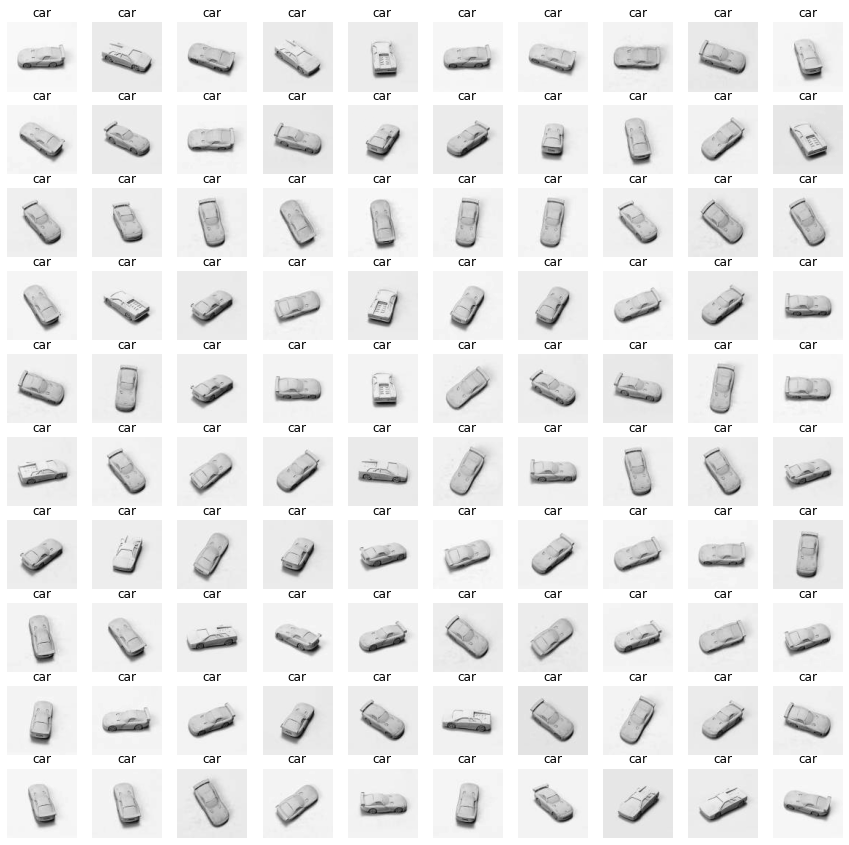

In [213]:
fig, axs = plt.subplots(10, 10,figsize=(15,15))

for i in range(10):
  for j in range(10):
    axs[i,j].imshow(train_images[i*10+j],cmap=plt.cm.gray)
    axs[i,j].set_title(lb.classes_[train_label_onehot[i*10+j].argmax()])
    axs[i,j].axis('off')


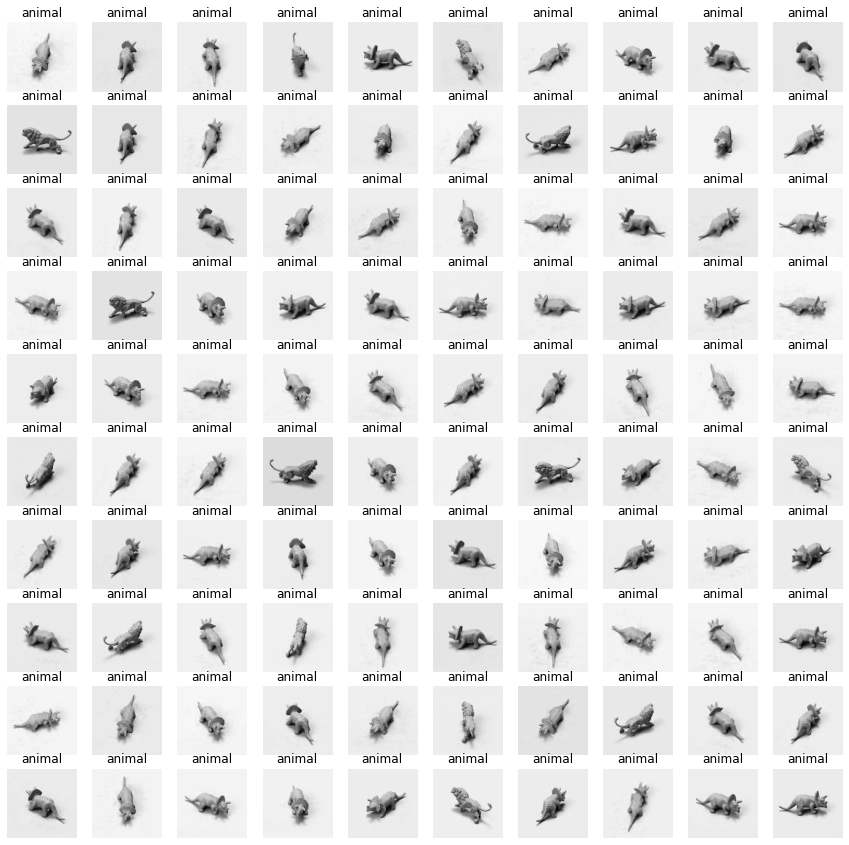

In [214]:
fig, axs = plt.subplots(10, 10,figsize=(15,15))

for i in range(10):
  for j in range(10):
    axs[i,j].imshow(train_images[200+i*10+j],cmap=plt.cm.gray)
    axs[i,j].set_title(lb.classes_[train_label_onehot[200+i*10+j].argmax()])
    axs[i,j].axis('off')


In [215]:
for ind in range (len(train_images)):
  img = train_images[ind]
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
  opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
  train_images[ind] = opening
for ind in range (len(val_images)):
  img = val_images[ind]
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
  opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
  val_images[ind] = opening
for ind in range (len(test_images)):
  img = test_images[ind]
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
  opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
  test_images[ind] = opening

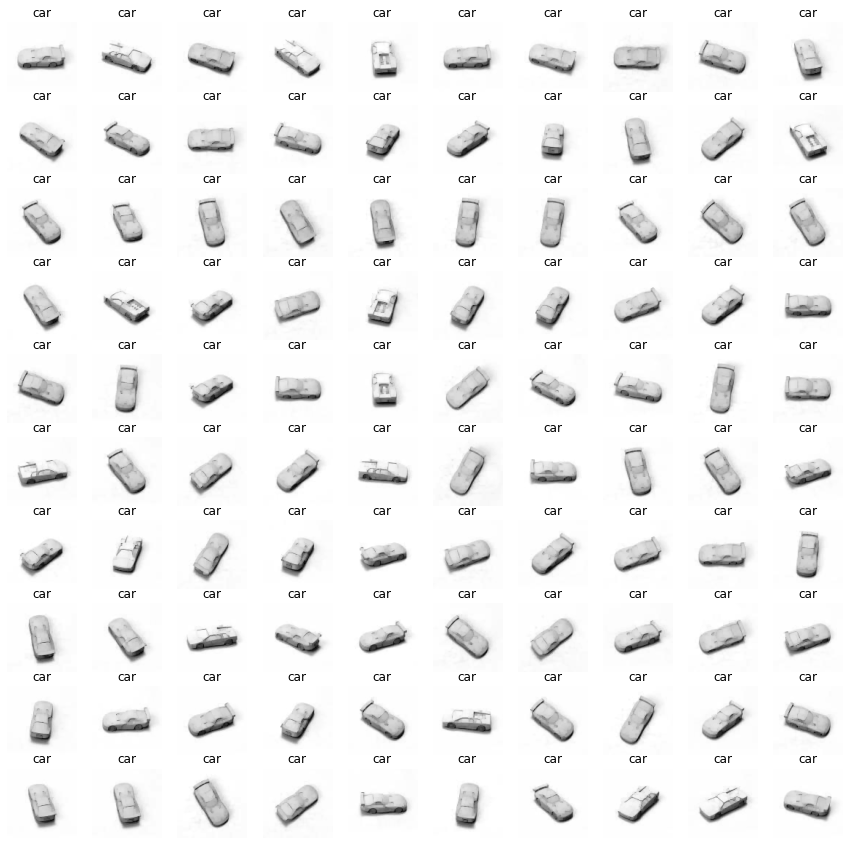

In [216]:
fig, axs = plt.subplots(10, 10,figsize=(15,15))

for i in range(10):
  for j in range(10):
    axs[i,j].imshow(train_images[i*10+j],cmap=plt.cm.gray)
    axs[i,j].set_title(lb.classes_[train_label_onehot[i*10+j].argmax()])
    axs[i,j].axis('off')

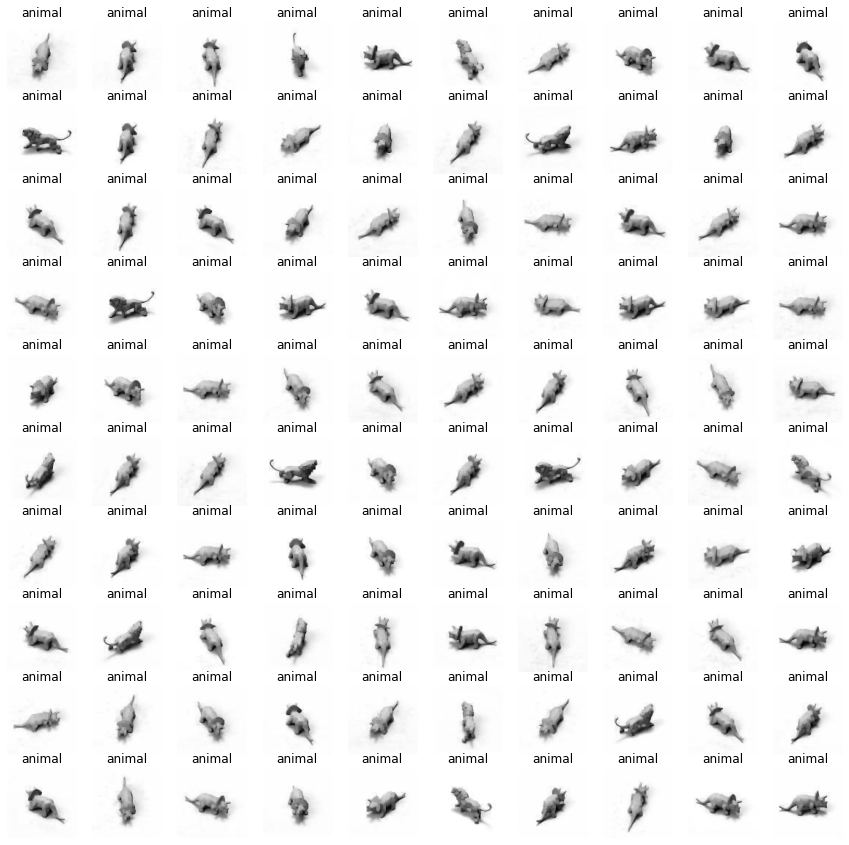

In [217]:
fig, axs = plt.subplots(10, 10,figsize=(15,15))

for i in range(10):
  for j in range(10):
    axs[i,j].imshow(train_images[200+i*10+j],cmap=plt.cm.gray)
    axs[i,j].set_title(lb.classes_[train_label_onehot[200+i*10+j].argmax()])
    axs[i,j].axis('off')


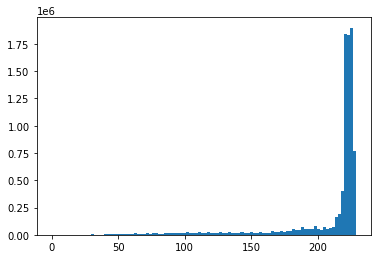

In [218]:
hist = plt.hist(train_images.flatten(),bins=100)

In [219]:
train_images_normalised = (train_images-train_images.mean())/train_images.std()
val_images_normalised = (val_images-val_images.mean())/val_images.std()
test_images_normalised = (test_images-test_images.mean())/test_images.std()

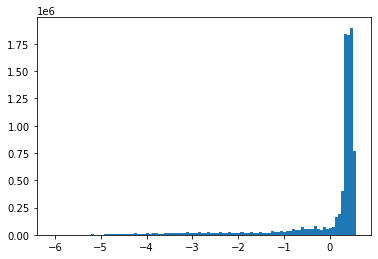

In [220]:
hist = plt.hist(train_images_normalised.flatten(),bins=100)

In [221]:
checkpoint = ModelCheckpoint("model_{epoch:02d}",monitor='val_loss',verbose=1,save_best_only=True)
adaptiveLearningRate = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5,verbose=1,min_delta=0.0001)
earlyStopping = EarlyStopping(monitor='val_loss',mode='auto',verbose=1,patience=25)
callback_list = [checkpoint,adaptiveLearningRate,earlyStopping]

In [222]:

def get_model(input_shape,num_of_class,hidden_size=64,dropout=0.5):
  input = tf.keras.Input(shape=(96,96,1))
  x_skip = input
  x = L.Conv2D(filters=32,kernel_size=(7,7),strides=(1,1), padding = 'same')(input)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x)
  x_skip = L.Conv2D(filters=32,kernel_size=(7,7),strides=(1,1), padding = 'same')(x_skip)
  x = L.Concatenate()([x, x_skip]) 
  x = L.MaxPool2D(pool_size=(2,2))(x)

  
  x_skip = x
  x = L.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1), padding = 'same')(x)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x)
  x_skip = L.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1), padding = 'same')(x_skip)
  x = L.Concatenate()([x, x_skip]) 
  x = L.MaxPool2D(pool_size=(2,2))(x)

  
  x_skip = x
  x = L.Conv2D(filters=128,kernel_size=(3,3),strides=(1,1), padding = 'same')(x)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x) 
  x_skip = L.Conv2D(filters=128,kernel_size=(3,3),strides=(1,1), padding = 'same')(x_skip)
  x = L.Concatenate()([x, x_skip]) 
  x = L.MaxPool2D(pool_size=(2,2))(x)

  x_skip = x
  x = L.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1), padding = 'same')(x)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x) 
  x_skip = L.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1), padding = 'same')(x_skip)
  x = L.Concatenate()([x, x_skip]) 
  x = L.MaxPool2D(pool_size=(2,2))(x)

  x = L.Flatten()(x)
  x = L.Dense(hidden_size)(x)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x)
  x = L.Dropout(dropout)(x)
  x = L.Dense(num_of_class,activation="softmax")(x)
  model = tf.keras.Model(input,x)
  return model

In [223]:
input_shape = (96,96,1)
num_of_class = len(lb.classes_)
K.clear_session()
model=get_model(input_shape,num_of_class)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=tf.keras.metrics.CategoricalAccuracy())
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 32)   1600        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 96, 96, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 96, 96, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

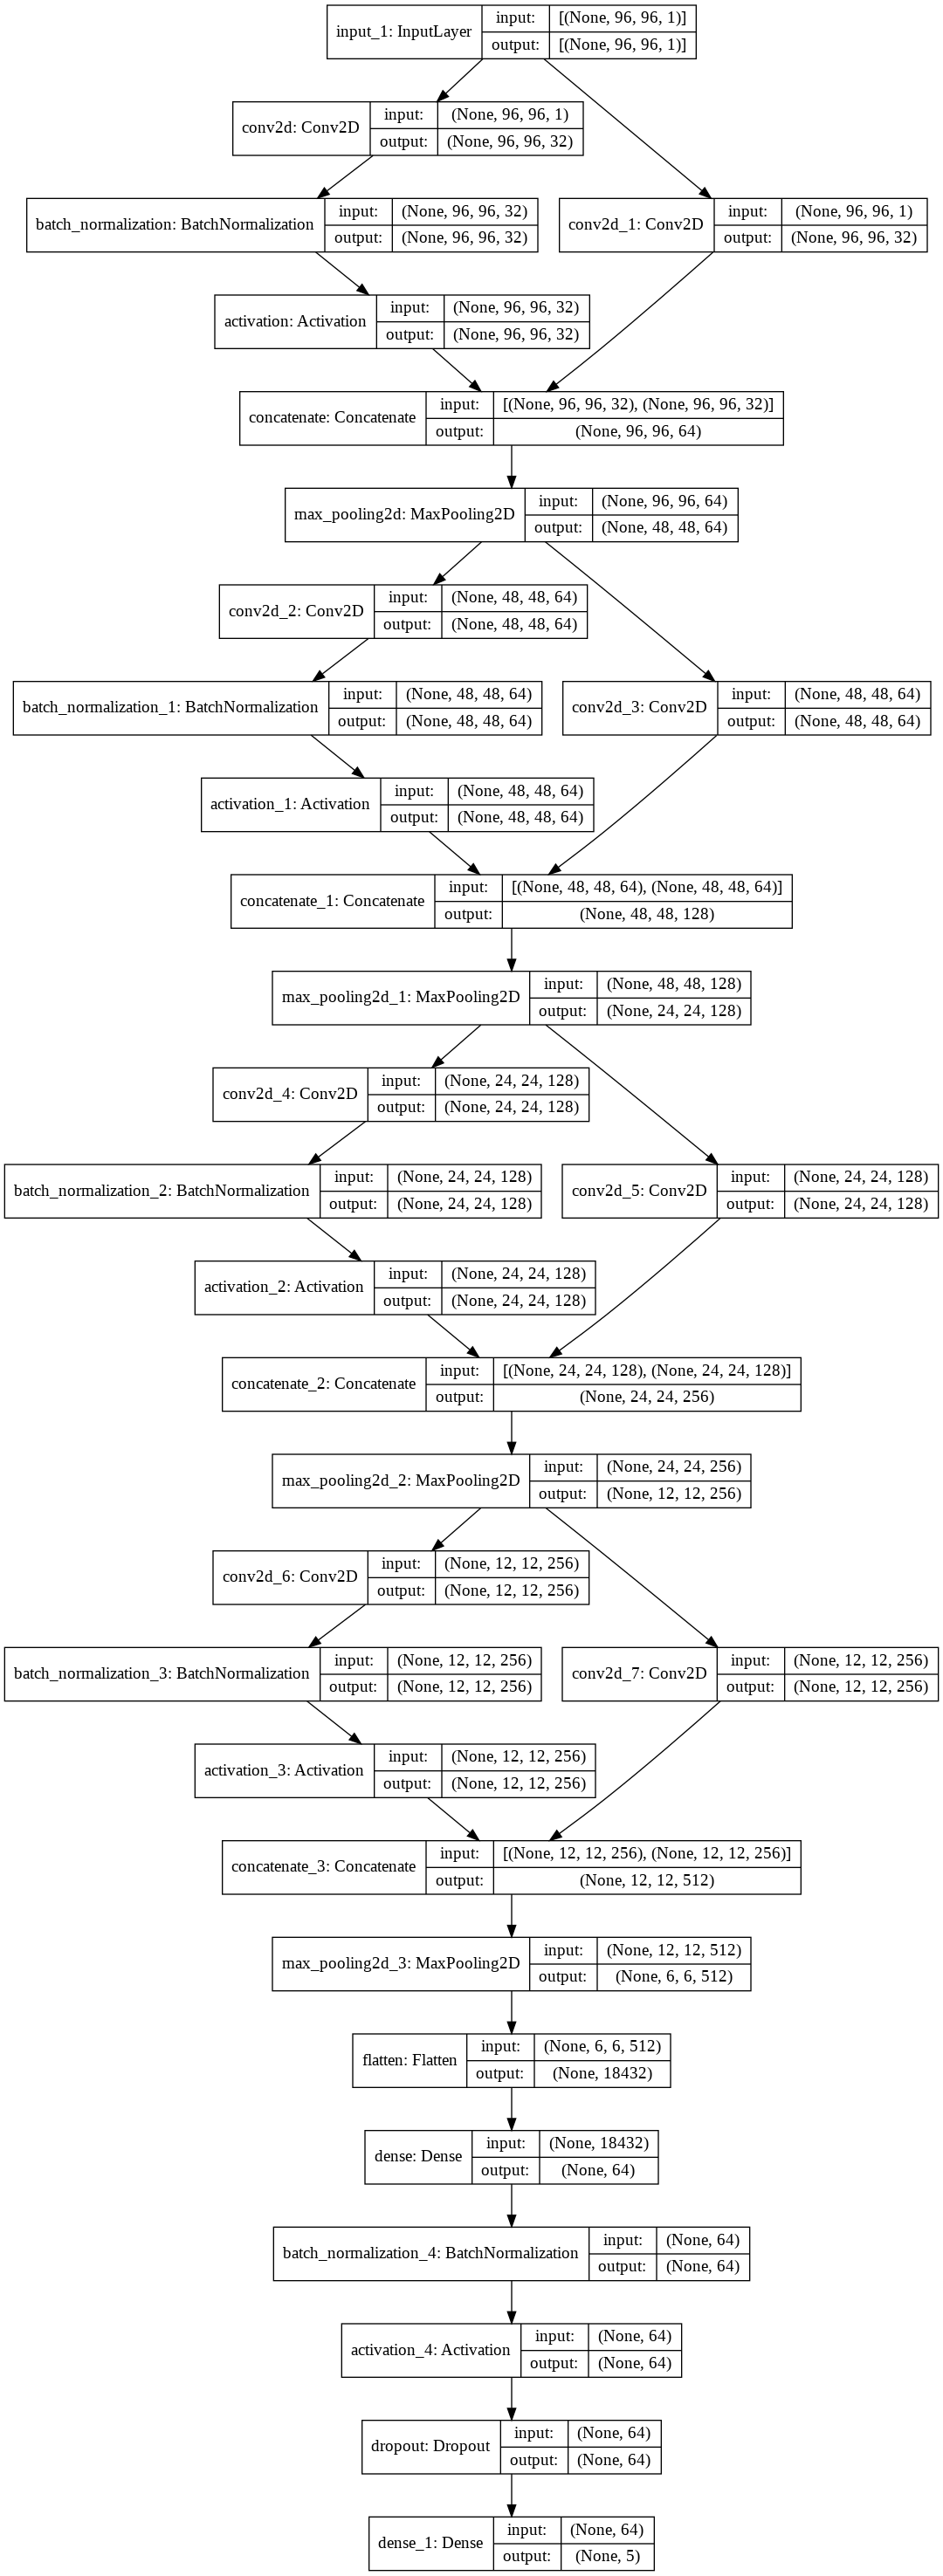

In [224]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
Augmented_training = ImageDataGenerator(rotation_range=2,
                                        fill_mode='nearest',
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        width_shift_range=0.01,
                                        height_shift_range=0.01)

In [225]:
BATCH_SIZE = 32
EPOCHS = 50
model.fit(
    Augmented_training.flow(np.expand_dims(val_images_normalised,3),val_label_onehot,batch_size=BATCH_SIZE),
    steps_per_epoch = len(np.expand_dims(val_images_normalised,3))//BATCH_SIZE,
    validation_data = (train_images_normalised,train_label_onehot),
    validation_steps=len(train_images_normalised)//BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = callback_list
)

Epoch 1/50
90/90 [==============================] - 9s 83ms/step - loss: 1.2509 - categorical_accuracy: 0.5024 - val_loss: 2.0744 - val_categorical_accuracy: 0.2196

Epoch 00001: val_loss improved from inf to 2.07439, saving model to model_01
INFO:tensorflow:Assets written to: model_01/assets
Epoch 2/50
90/90 [==============================] - 7s 79ms/step - loss: 0.8139 - categorical_accuracy: 0.6793 - val_loss: 2.7400 - val_categorical_accuracy: 0.2052

Epoch 00002: val_loss did not improve from 2.07439
Epoch 3/50
90/90 [==============================] - 7s 78ms/step - loss: 0.6410 - categorical_accuracy: 0.7630 - val_loss: 2.2178 - val_categorical_accuracy: 0.3670

Epoch 00003: val_loss did not improve from 2.07439
Epoch 4/50
90/90 [==============================] - 7s 78ms/step - loss: 0.5517 - categorical_accuracy: 0.8051 - val_loss: 1.8217 - val_categorical_accuracy: 0.4711

Epoch 00004: val_loss improved from 2.07439 to 1.82167, saving model to model_04
INFO:tensorflow:Assets wr

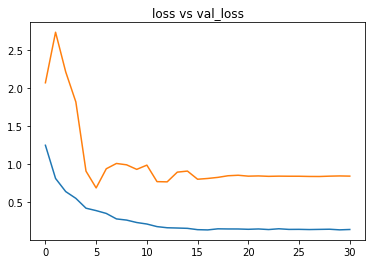

In [226]:
fig=plt.figure()
plt.plot(model.history.history["loss"],label="loss")
plt.plot(model.history.history["val_loss"],label="val_loss")
plt.title("loss vs val_loss")
plt.show()

In [227]:
prediction = model.predict(val_images_normalised)
print("Train classification report")
print(classification_report(val_label_onehot.argmax(axis=1),prediction.argmax(axis=1),target_names=lb.classes_))

Train classification report
              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00       582
      animal       1.00      0.97      0.98       582
         car       1.00      1.00      1.00       582
       human       0.97      1.00      0.98       582
       truck       1.00      1.00      1.00       582

    accuracy                           0.99      2910
   macro avg       0.99      0.99      0.99      2910
weighted avg       0.99      0.99      0.99      2910



In [228]:
prediction = model.predict(train_images_normalised)
print("Val classification report")
print(classification_report(train_label_onehot.argmax(axis=1),prediction.argmax(axis=1),target_names=lb.classes_))

Val classification report
              precision    recall  f1-score   support

    airplane       0.72      0.90      0.80       194
      animal       0.91      0.21      0.34       194
         car       0.82      0.67      0.74       194
       human       0.66      0.97      0.79       194
       truck       0.75      0.92      0.83       194

    accuracy                           0.74       970
   macro avg       0.77      0.74      0.70       970
weighted avg       0.77      0.74      0.70       970



In [229]:
prediction = model.predict(test_images_normalised)

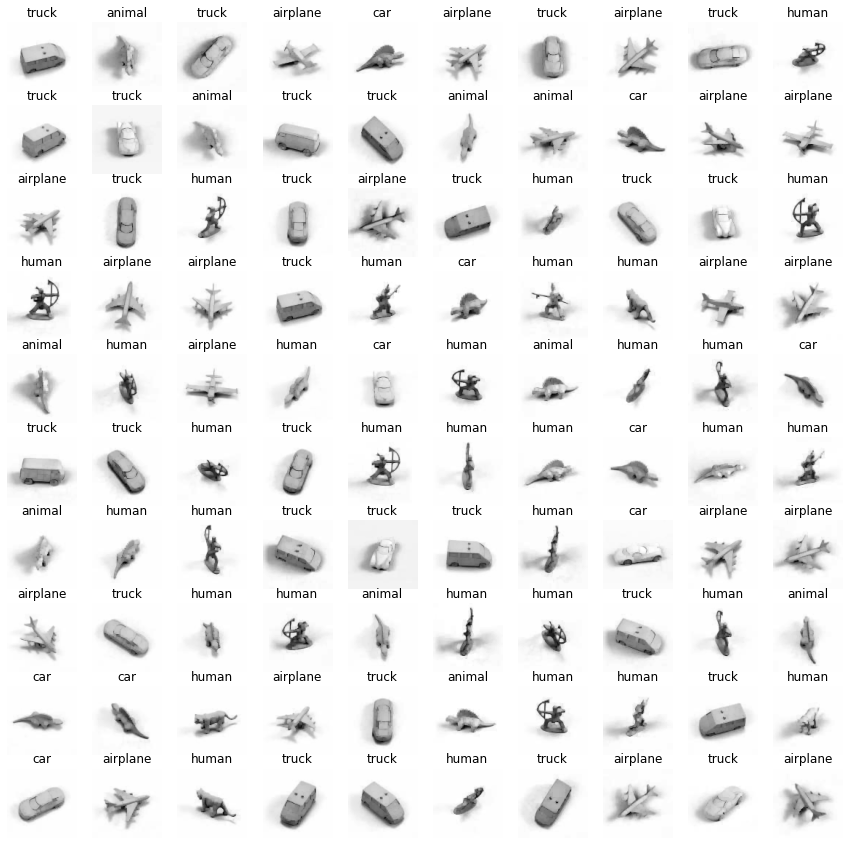

In [230]:
fig, axs = plt.subplots(10, 10,figsize=(15,15))
for i in range(10):
  for j in range(10):
    axs[i,j].imshow(test_images[i*10+j],cmap=plt.cm.gray)
    axs[i,j].set_title(lb.classes_[prediction[i*10+j].argmax()])
    axs[i,j].axis('off')

In [236]:
import pandas as pd

In [237]:
data = []
for i,path in enumerate(test_images_path):
  data.append([path.split(os.sep)[-1],lb.classes_[prediction[i].argmax()]])


In [238]:
df = pd.DataFrame(data=data,columns=['Image_Name','Label'])

In [240]:
df.head()

,Image_Name,Label
0,036298_02_lt.jpg,truck
1,037190_02_lt.jpg,animal
2,038784_02_lt.jpg,truck
3,039772_03_lt.jpg,airplane
4,034105_02_lt.jpg,car


In [239]:
df.to_csv("Submission.csv")

In [ ]:
drive.flush_and_unmount()